## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import configparser as cp
import warnings

# Ignore Eikon python library deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
# ------------------- Load data from Reuters -------------------

def load_reuters_data(ticker_ric, data_folder = "data") -> pd.DataFrame: 
    """
    Load timeseries data from Reuters
    """

    close_df              = pd.read_excel(f'{data_folder}/{ticker_ric}/Close.xlsx', index_col = 0, parse_dates = True)
    shares_outstanding_df = pd.read_excel(f'{data_folder}/{ticker_ric}/TR.IssueSharesOutstanding.xlsx', index_col = 0, parse_dates = True)
    market_cap_df         = pd.read_excel(f'{data_folder}/{ticker_ric}/TR.CompanyMarketCapitalization.xlsx', index_col = 0, parse_dates = True)
    total_assets_df       = pd.read_excel(f'{data_folder}/{ticker_ric}/TR.TotalAssets.xlsx', index_col = 0, parse_dates = True)
    total_debt_df         = pd.read_excel(f'{data_folder}/{ticker_ric}/TR.TotalDebtOutstanding.xlsx', index_col = 0, parse_dates = True)
    # at1_debt_df           = pd.read_excel(f'{data_folder}/cs_at1_debt.xlsx', index_col = 0, parse_dates = True)

    # Drop duplicates
    # TODO: see if we can not do this in the first place
    close_df              = close_df[~close_df.index.duplicated(keep='first')]
    shares_outstanding_df = shares_outstanding_df[~shares_outstanding_df.index.duplicated(keep='first')]
    market_cap_df         = market_cap_df[~market_cap_df.index.duplicated(keep='first')]
    total_assets_df       = total_assets_df[~total_assets_df.index.duplicated(keep='first')]
    total_debt_df         = total_debt_df[~total_debt_df.index.duplicated(keep='first')]
    # at1_debt_df           = at1_debt_df[~at1_debt_df.index.duplicated(keep='first')]

    # Fill days inbetween with the last available value
    start_date = close_df.index.min()
    end_date = close_df.index.max()
    full_range = pd.date_range(
        start=start_date - pd.DateOffset(years=1),
        end=end_date,
    )
    close_df = close_df.reindex(full_range).ffill()
    shares_outstanding_df = shares_outstanding_df.reindex(full_range).ffill()
    market_cap_df = market_cap_df.reindex(full_range).ffill()
    total_assets_df = total_assets_df.reindex(full_range).ffill()
    total_debt_df = total_debt_df.reindex(full_range).ffill()
    # at1_debt_df = at1_debt_df.reindex(full_range).ffill()

    # Remove non-business days
    full_range = pd.date_range(
        start=start_date,
        end=end_date,
        freq='B'
    )
    close_df = close_df.reindex(full_range)
    shares_outstanding_df = shares_outstanding_df.reindex(full_range)
    market_cap_df = market_cap_df.reindex(full_range)
    total_assets_df = total_assets_df.reindex(full_range)
    total_debt_df = total_debt_df.reindex(full_range)
    # at1_debt_df = at1_debt_df.reindex(full_range)

    input_data = close_df.merge(shares_outstanding_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(market_cap_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_assets_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_debt_df, left_index=True, right_index=True, how='left')
    # input_data = input_data.merge(at1_debt_df, left_index=True, right_index=True, how='left')

    return input_data


class DCL_Bond:
    def __init__(self, name, ticker_ric, Q_init, L_min, L_c, S_p, r, T_years = 10, freq = 1):
        self.name = name
        
        # Load ticker data exported from Reuters Eikon
        self.ticker_ric = ticker_ric
        self.reuters_data = load_reuters_data(ticker_ric)

        # Initialize the results dataframe
        self.dcl_data = self.reuters_data.copy()
        self.dcl_data["Market cap / Share price"] = self.dcl_data["Company Market Capitalization"] / self.dcl_data["Close"]
        
        self.Q_init = Q_init # Initial nominal value of the DCL bond
        self.L_min = L_min   # Min leverage ratio trigger
        self.L_c = L_c       # Max leverage ratio trigger
        
        # Set conversion price
        if S_p == "initial share price": # Sets the first close price in the time series as S_p
            self.S_p = self.dcl_data['Close'][0]
        elif type(S_p) == int or type(S_p) == float: # We don't accept np.float as input
            self.S_p = S_p
        else:
            raise ValueError
        
        self.r = r
        self.T_years = T_years
        self.freq = freq

        self.results = self.simulate_DCL()

    def calculate_residual_value_of_dcl(self, Q, r, T_years, k_years):
        """
        Calculate the residual value of DCL bond at time k. 
        """

        return Q * ((1 + r)**k_years + (1 - (1 + r)**k_years)/(1 - (1 + r)**(-T_years)))

    def calculate_alpha(self, RQ_k, total_debt):
        """
        Calculate the ratio of CoCos to total debt. 
        """
        
        return RQ_k / total_debt

    def calculate_leverage_ratio(self, RQ_k, NS_k_1, S_k, alpha_k):
        """
        Calculate the leverage ratio. 
        """

        return RQ_k / (RQ_k + alpha_k * NS_k_1 * S_k)

    def compute_period_index(self, dates):
        """
        Given a DatetimeIndex, returns two arrays:
        - period_array: which 'period' you are in 
        - k_array: how many 'periods' have passed since the start
        
        """
        if self.freq == 365: # Daily
            # Number of days since the start date
            base = dates[0]
            day_counts = (dates - base).days
            return day_counts, day_counts  # (period, k) are effectively the same
        
        elif self.freq == 12: # Monthly
            # A convenient measure: year*12 + month
            base_year  = dates[0].year
            base_month = dates[0].month
            
            period_array = (dates.year - base_year) * 12 + (dates.month - base_month)
            return period_array, period_array
        
        elif self.freq == 2: # Bi-annual
            # Count how many 6-month periods have passed since the start
            base_year = dates[0].year
            base_month = dates[0].month
            base_half_year = (base_month - 1) // 6  # 0 for Jan-Jun, 1 for Jul-Dec
            
            period_array = (dates.year - base_year) * 2 + ((dates.month - 1) // 6) - base_half_year
            return period_array, period_array
        
        elif self.freq == 1: # yearly
            base_year = dates[0].year
            year_offset = (dates.year - base_year)
            return year_offset, year_offset
        
        elif self.freq == 0: # No DCL (no rebalancing)
            return np.zeros(len(dates)), np.zeros(len(dates))
        
        else:
            raise ValueError(f"Invalid frequency '{self.freq}'.")


    def simulate_DCL(self):
        """
        Simulate the DCL model. 
        """

        period_array, k_array = self.compute_period_index(dates = self.dcl_data.index)
        # print(period_array)
        # print(k_array)
        self.dcl_data['period'] = period_array
        # self.dcl_data['k'] = self.dcl_data.index.year - self.dcl_data.index.year[0]
        self.dcl_data['k']      = k_array

        # Conversion constant for period number to year
        if self.freq == 0:
            period_to_years = 99999
        else:
            period_to_years = 1 / self.freq
        
        # self.dcl_data['Book value of debt'] = self.dcl_data['Total Debt']
        # self.dcl_data['Shares outstanding'] = self.dcl_data['Common Shares - Outstanding - Total']
        self.dcl_data['Shares outstanding'] = self.dcl_data['Issue Default Shares Outstanding'][0]
        self.dcl_data['Q']                  = self.Q_init
        self.dcl_data['Top up loan']        = 0.0
        self.dcl_data['New shares issued']  = 0.0
        self.dcl_data['RQ_k']               = np.nan
        self.dcl_data['alpha_k']              = np.nan
        # self.dcl_data['Leverage ratio']     = np.nan
        self.dcl_data['Payment size'] = 0

        all_dates = self.dcl_data.index
        for idx, day in enumerate(all_dates):
            # Compute the fraction of a year that has elapsed for this k
            k_in_years = self.dcl_data.loc[day, 'k'] * period_to_years

            if idx != 0:
                # By default, carry forward the nominal Q from prior day
                previous_day = self.dcl_data.index[idx - 1]
                self.dcl_data.loc[day, 'Q'] = self.dcl_data.loc[previous_day, 'Q']

            self.dcl_data.loc[day, 'RQ_k'] = self.calculate_residual_value_of_dcl( # Compute the residual value of DCL
                self.dcl_data.loc[day, 'Q'], 
                self.r, 
                self.T_years, 
                k_in_years,
            )
            self.dcl_data.loc[day, 'alpha_k'] = self.calculate_alpha( # Compute alpha_k (the proportion of DCL to total debt)
                self.dcl_data.loc[day, 'RQ_k'], 
                self.dcl_data.loc[day, 'Total Debt']
            )
            self.dcl_data.loc[day, 'Leverage ratio'] = self.calculate_leverage_ratio( # Compute the leverage ratio
                self.dcl_data.loc[day, 'RQ_k'], 
                self.dcl_data.loc[day, 'Shares outstanding'], 
                self.dcl_data.loc[day, 'Close'],
                self.dcl_data.loc[day, 'alpha_k'],
            )

            # On the very first day, we just fill RQ_k but do no payments / rebalancing
            if idx == 0:
                continue


            # TODO: Check for correctness (T_years * freq ?)
            if self.freq != 0:
                self.dcl_data.loc[day, 'Payment size'] = self.r * self.dcl_data.loc[day, 'Q'] / (1 - (1 + self.r)**(-self.T_years * self.freq))
            # We only rebalance once per "period" change under freq.
            # For example, if freq='monthly', this triggers once a new month starts.
            if self.dcl_data.loc[day, 'period'] != self.dcl_data.loc[previous_day, 'period']:
                L_k = self.dcl_data.loc[day, 'Leverage ratio']

                if L_k < self.L_min: # In this case, issue new debt to raise the leverage ratio
                    # print(f"{day} - Leverage ratio is below minimum: L_k = {L_k}")
                    self.dcl_data.loc[day, 'Top up loan'] = -self.dcl_data.loc[day, 'RQ_k'] + self.L_min * self.dcl_data.loc[day, 'Shares outstanding'] * self.dcl_data.loc[day, 'Close'] / (1 - self.L_min)
                    # print(f"{day} - Top up loan: {self.dcl_data.loc[day, 'Top up loan']:,.2f}")
                    self.dcl_data.loc[day, 'Q'] += self.dcl_data.loc[day, 'Top up loan'] # Nominal of the DCL
                    self.dcl_data.loc[day, 'Total Debt'] += self.dcl_data.loc[day, 'Top up loan'] # Total debt of the company

                    # Recompute the residual value of DCL
                    self.dcl_data.loc[day, 'RQ_k'] = self.calculate_residual_value_of_dcl(
                        self.dcl_data.loc[day, 'Q'], 
                        self.r, 
                        self.T_years, 
                        k_in_years,
                    )

                elif L_k > self.L_c: # In this case, convert DCL interest payments to new shares instead
                    # print(f"{day} - Leverage ratio is above critical: L_k = {L_k}")

                    # New shares issued for converting the interest payment to shares
                    shares_issued = self.dcl_data.loc[day, 'Payment size'] / self.S_p

                    # New shares issued to make the leverage ratio be exactly at L_c
                    shares_issued_to_L_c = self.dcl_data.loc[day, 'RQ_k'] * (1 - self.L_c) / (self.L_c * self.dcl_data.loc[day, 'alpha_k'] * self.dcl_data.loc[day, 'Close']) - self.dcl_data.loc[day, 'Shares outstanding']
                    
                    # We don't convert beyond the leverage ratio
                    if shares_issued > shares_issued_to_L_c: 
                        shares_issued = shares_issued_to_L_c 

                    # print(f"{day} - New shares issued: {self.dcl_data.loc[day, 'New shares issued']}")
                    if shares_issued > 0:
                        self.dcl_data.loc[day:, 'Shares outstanding'] = self.dcl_data.loc[day:, 'Shares outstanding'] + shares_issued

                    self.dcl_data.loc[day, 'New shares issued'] = shares_issued # Document additional shares issued

                if k_in_years >= self.T_years:
                    print(f"Final k in years for freq {self.freq}: ", k_in_years)
                    break




        self.dcl_data.to_excel(f'data/{self.ticker_ric}/Results - frequency {self.freq}.xlsx')
        return self.dcl_data
    
    def plot_input_data(self):
        """
        Plot the stock data. 
        """

        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 12))
        fig.suptitle("Input data", fontsize=14)
        self.dcl_data["Close"].plot(ax=ax[0])
        ax[0].set_title("Share price - Close") 
        self.dcl_data["Issue Default Shares Outstanding"].plot(ax=ax[1])
        ax[1].set_title("Shares outstanding")
        ax[2].set_title("Market cap / Share price")
        self.dcl_data["Market cap / Share price"].plot(ax=ax[2])
        self.dcl_data["Company Market Capitalization"].plot(ax=ax[3])
        ax[3].set_title("Equity Value")
        self.dcl_data["Total Debt"].plot(ax=ax[4])
        ax[4].set_title("Total Debt")
        plt.tight_layout()
        plt.savefig(f"images/input_data.png")
        plt.show()



# =========================================================================
#                              Simulations
# =========================================================================

# --------------------------  Credit Suisse -------------------------------

cs_r = 0.05
cs_Q_init = 10_216_000_000 # Initial nominal value of DCL bonds -> Set as initial AT1 debt value
# cs_L_min = 0
cs_L_min = 0.85
# cs_L_c   = 1
cs_L_c   = 0.9

cs_dcl_daily = DCL_Bond(
    name       = "Credit Suisse - Daily",
    ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = cs_Q_init,             # Initial value of DCL bonds
    L_min      = cs_L_min,              # Minimum leverage ratio
    L_c        = cs_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = cs_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 365,                   # Frequency of interest payments and leverage considerations
)

cs_dcl_monthly = DCL_Bond(
    name       = "Credit Suisse - Monthly",
    ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = cs_Q_init,             # Initial value of DCL bonds
    L_min      = cs_L_min,              # Minimum leverage ratio
    L_c        = cs_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = cs_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 12,             # Frequency of interest payments and leverage considerations
)

cs_dcl_biannual = DCL_Bond(
    name       = "Credit Suisse - Bi-annual",
    ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = cs_Q_init,             # Initial value of DCL bonds
    L_min      = cs_L_min,              # Minimum leverage ratio
    L_c        = cs_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = cs_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 2,            # Frequency of interest payments and leverage considerations
) # TODO: bi-annual

cs_dcl_yearly = DCL_Bond(
    name       = "Credit Suisse - Yearly",
    ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = cs_Q_init,             # Initial value of DCL bonds
    L_min      = cs_L_min,              # Minimum leverage ratio
    L_c        = cs_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = cs_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 1,              # Frequency of interest payments and leverage considerations
)

# No DCL bond, freq = 0
cs_no_dcl = DCL_Bond(
    name       = "Credit Suisse - No DCL",
    ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = 1,                     # Initial value of DCL bonds
    L_min      = cs_L_min,              # Minimum leverage ratio
    L_c        = cs_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = cs_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 0,         # Frequency of interest payments and leverage considerations
)

# cs_dcl_yearly.reuters_input_data
cs_dcl_yearly.results



,Close,Issue Default Shares Outstanding,Company Market Capitalization,Total Assets,Total Debt,Market cap / Share price,period,k,Shares outstanding,Q,Top up loan,New shares issued,RQ_k,alpha_k,Payment size,Leverage ratio
2015-01-05,21.686784,1.607169e+09,4.148007e+10,9.214620e+11,3.007920e+11,1.912689e+09,0,0,1.607169e+09,10216000000,0.0,0.0,1.021600e+10,0.033964,0.000000e+00,0.896158
2015-01-06,21.313945,1.607169e+09,4.076694e+10,9.214620e+11,3.007920e+11,1.912689e+09,0,0,1.607169e+09,10216000000,0.0,0.0,1.021600e+10,0.033964,1.323019e+09,0.897760
2015-01-07,21.216297,1.607169e+09,4.058017e+10,9.214620e+11,3.007920e+11,1.912689e+09,0,0,1.607169e+09,10216000000,0.0,0.0,1.021600e+10,0.033964,1.323019e+09,0.898181
2015-01-08,21.509242,1.607169e+09,4.114049e+10,9.214620e+11,3.007920e+11,1.912689e+09,0,0,1.607169e+09,10216000000,0.0,0.0,1.021600e+10,0.033964,1.323019e+09,0.896920
2015-01-09,20.967738,1.607169e+09,4.010476e+10,9.214620e+11,3.007920e+11,1.912689e+09,0,0,1.607169e+09,10216000000,0.0,0.0,1.021600e+10,0.033964,1.323019e+09,0.899254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,4.002158e+09,3.240147e+09,5.313580e+11,1.929070e+11,4.002158e+09,8,8,2.034209e+09,10216000000,0.0,0.0,2.460035e+09,0.012752,1.323019e+09,0.991535
2023-06-07,0.810200,4.002158e+09,3.242548e+09,5.313580e+11,1.929070e+11,4.002158e+09,8,8,2.034209e+09,10216000000,0.0,0.0,2.460035e+09,0.012752,1.323019e+09,0.991529
2023-06-08,0.811000,4.002158e+09,3.245750e+09,5.313580e+11,1.929070e+11,4.002158e+09,8,8,2.034209e+09,10216000000,0.0,0.0,2.460035e+09,0.012752,1.323019e+09,0.991521
2023-06-09,0.808000,4.002158e+09,3.233744e+09,5.313580e+11,1.929070e+11,4.002158e+09,8,8,2.034209e+09,10216000000,0.0,0.0,2.460035e+09,0.012752,1.323019e+09,0.991552


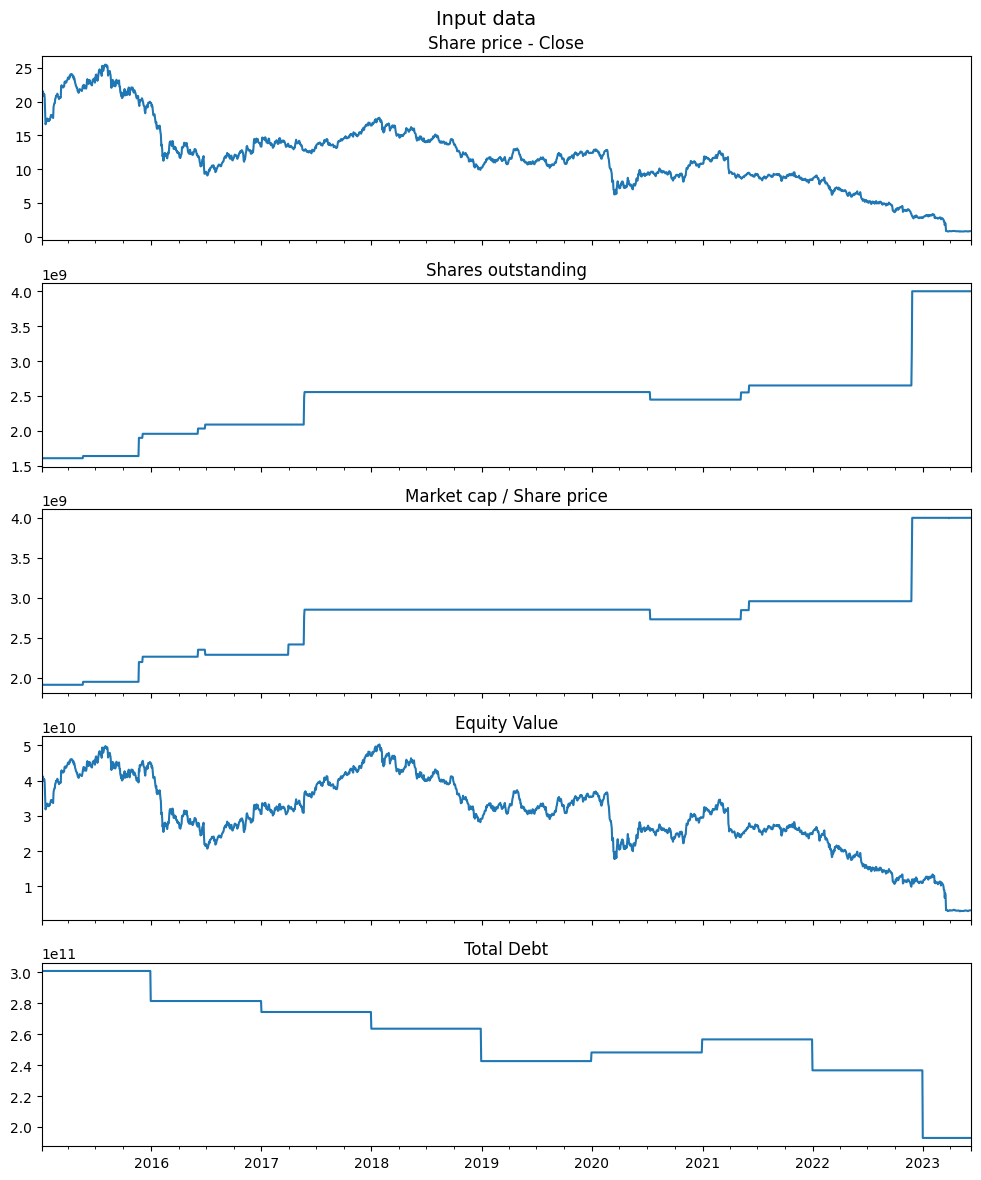

In [15]:
# --------------------- Plot the input data ---------------------

cs_dcl_yearly.plot_input_data()


$RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m}))$ (only applies if the triggers are not breached)

$L_k = \text{Total debt} / (\text{Total equity} + \text{Total debt}) = RQ_k / (RQ_k + NS_{k-1} * S_k)$

$\alpha = RQ_k / (RQ_k + \text{Book value of non CoCo debt})$

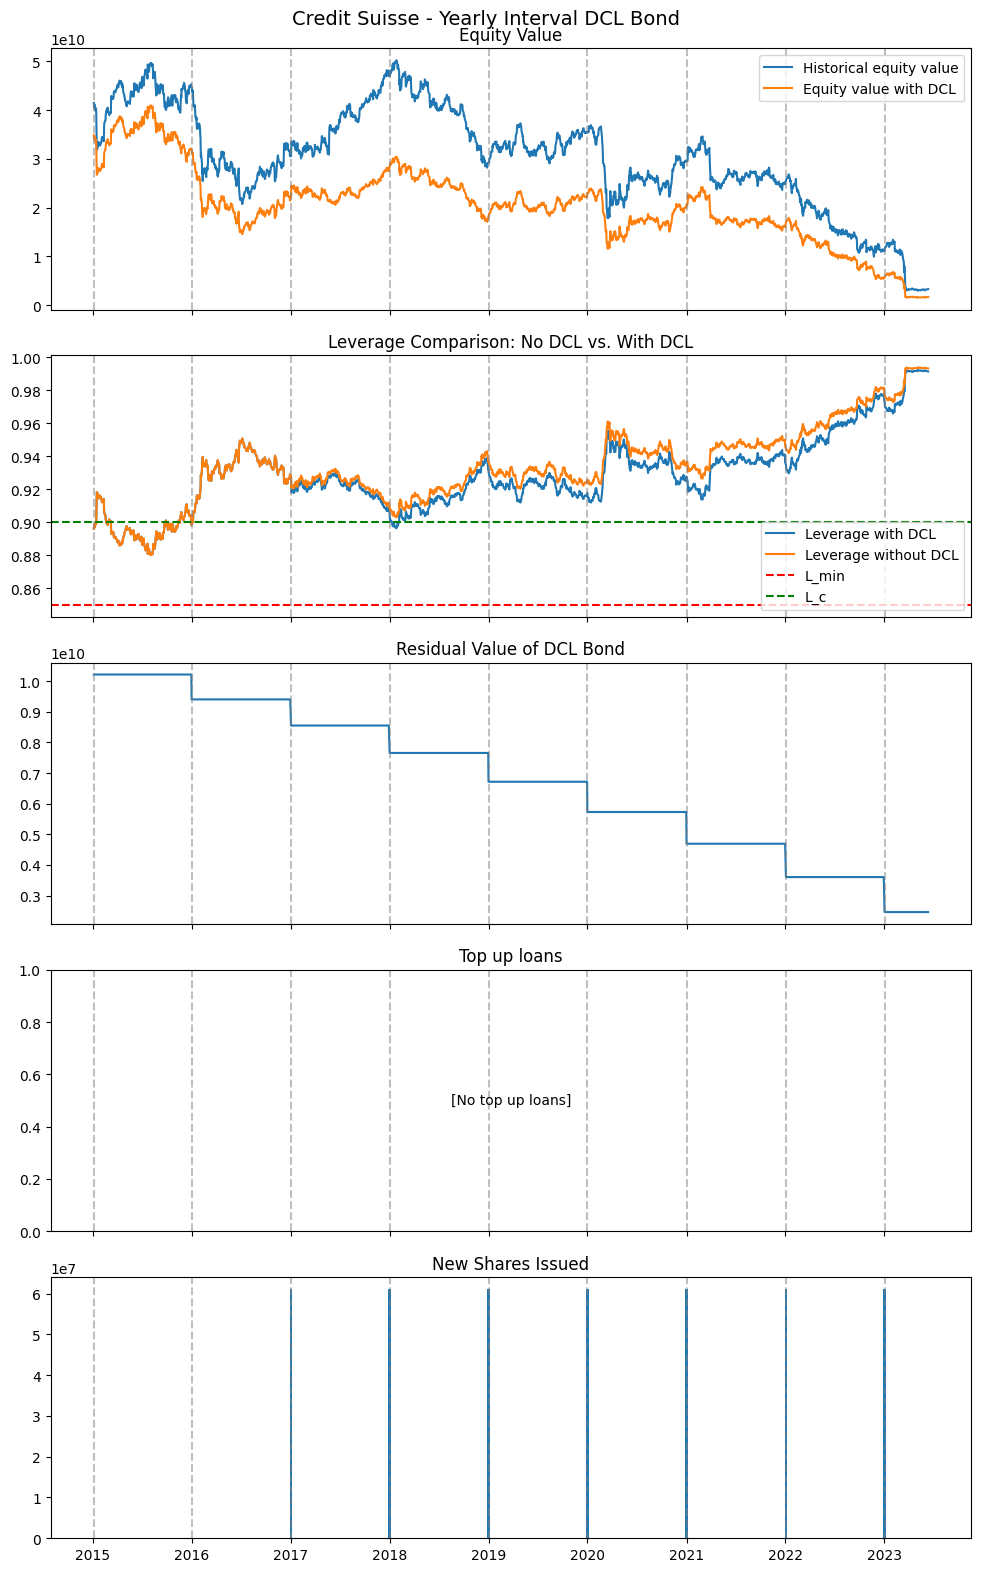

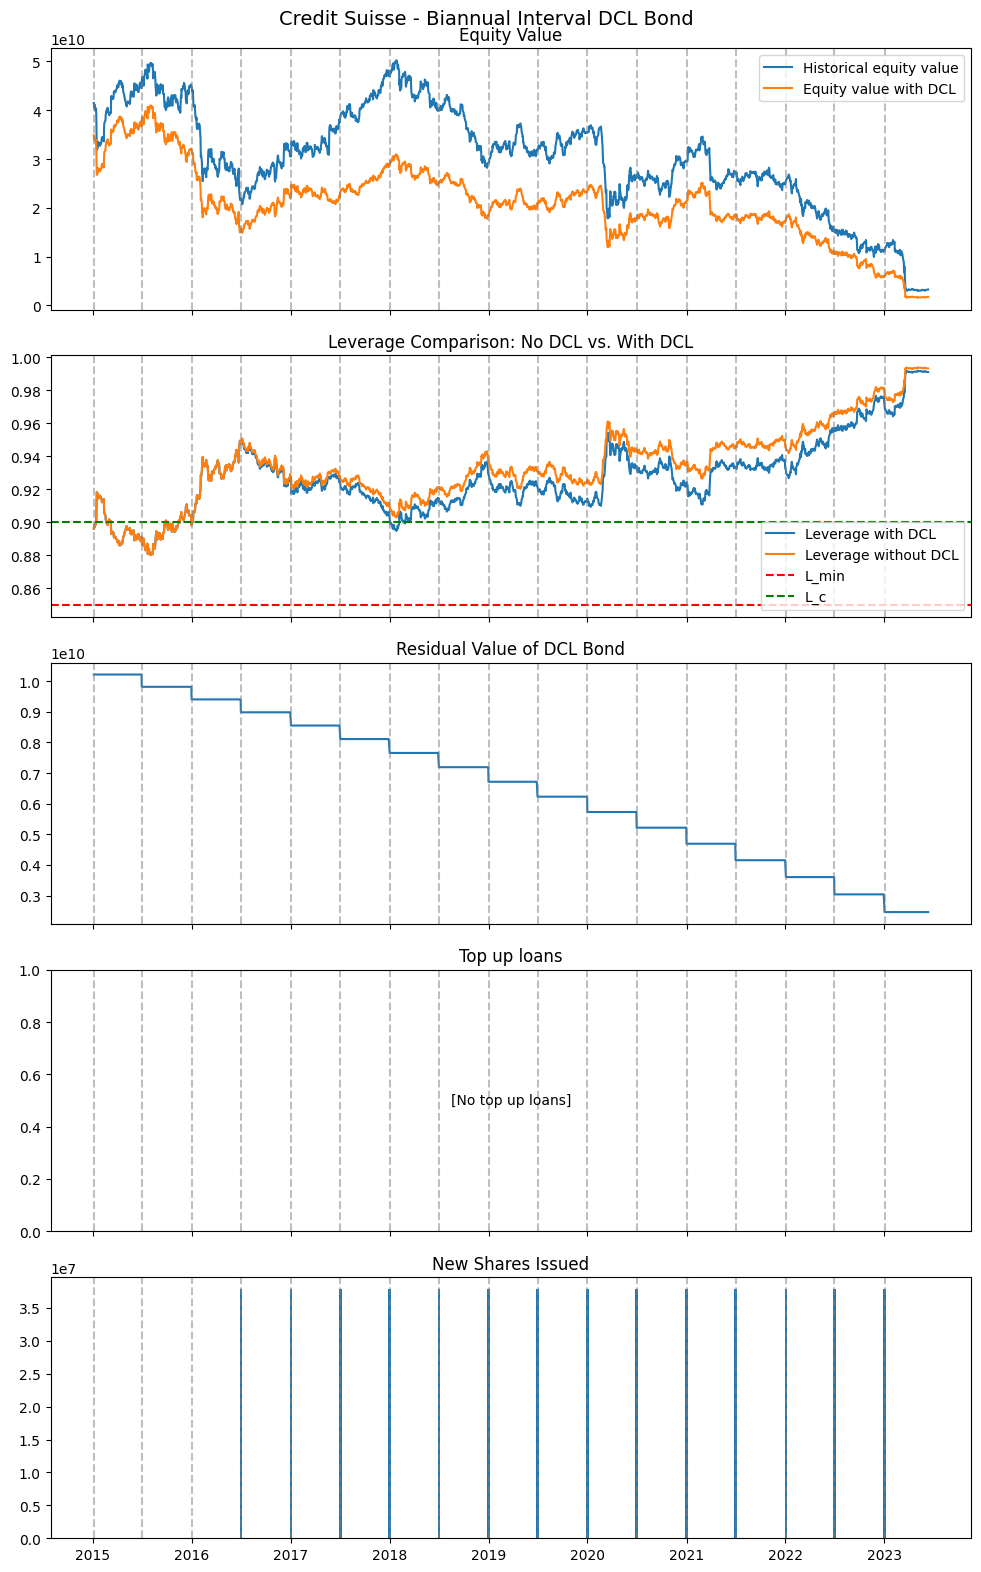

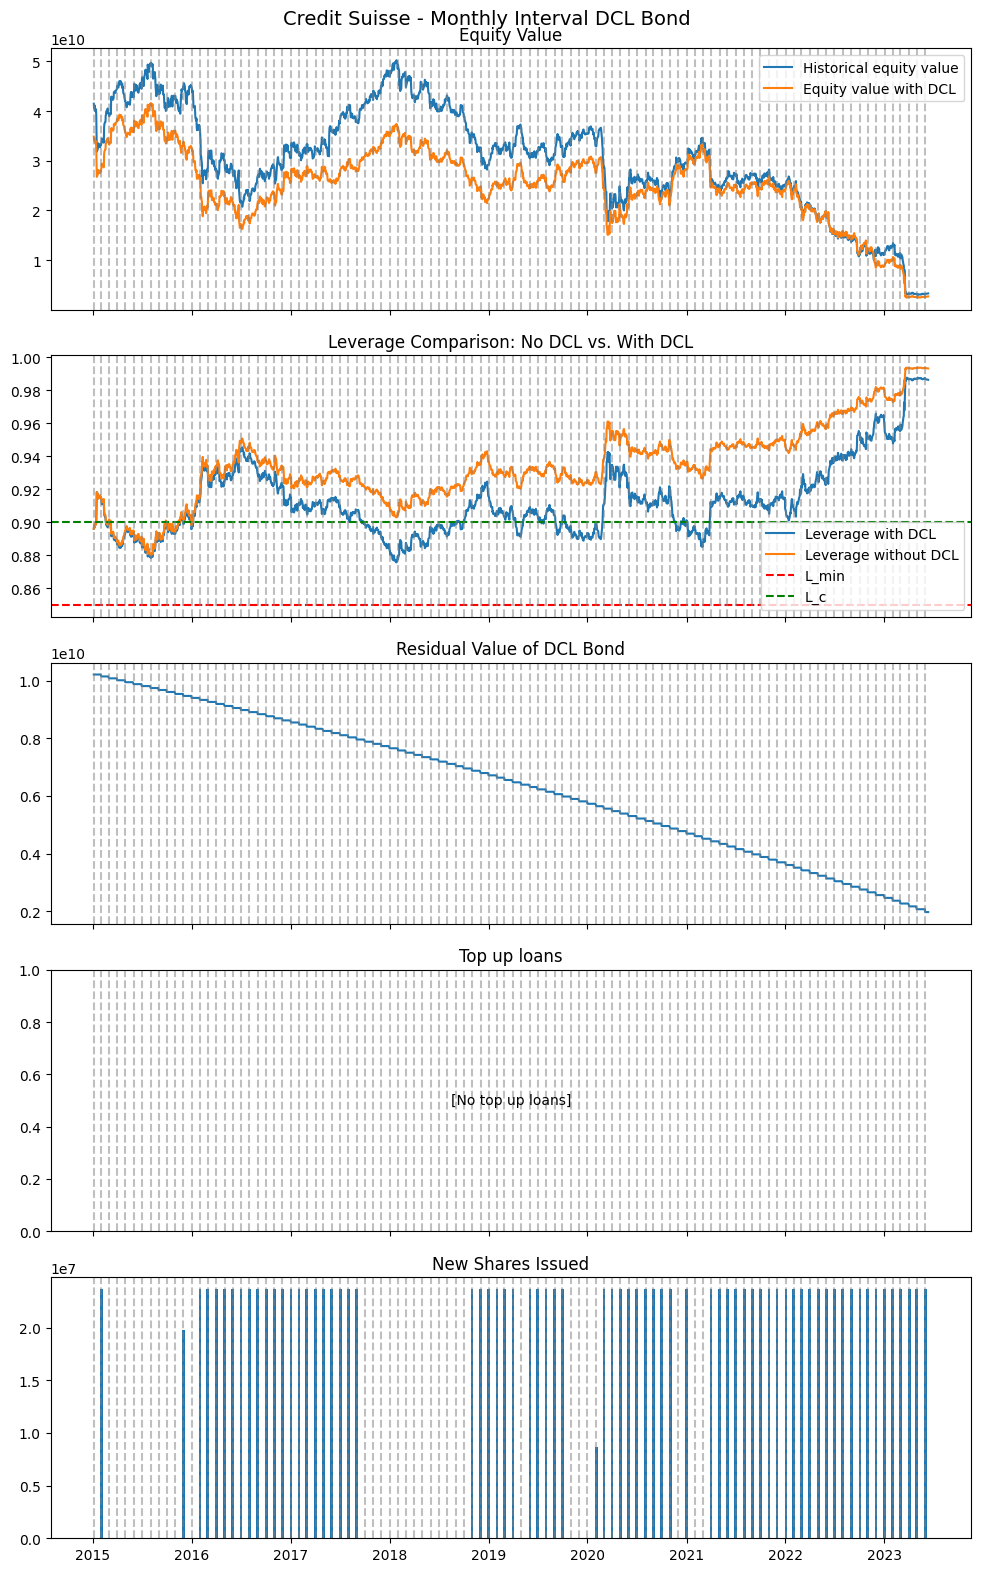

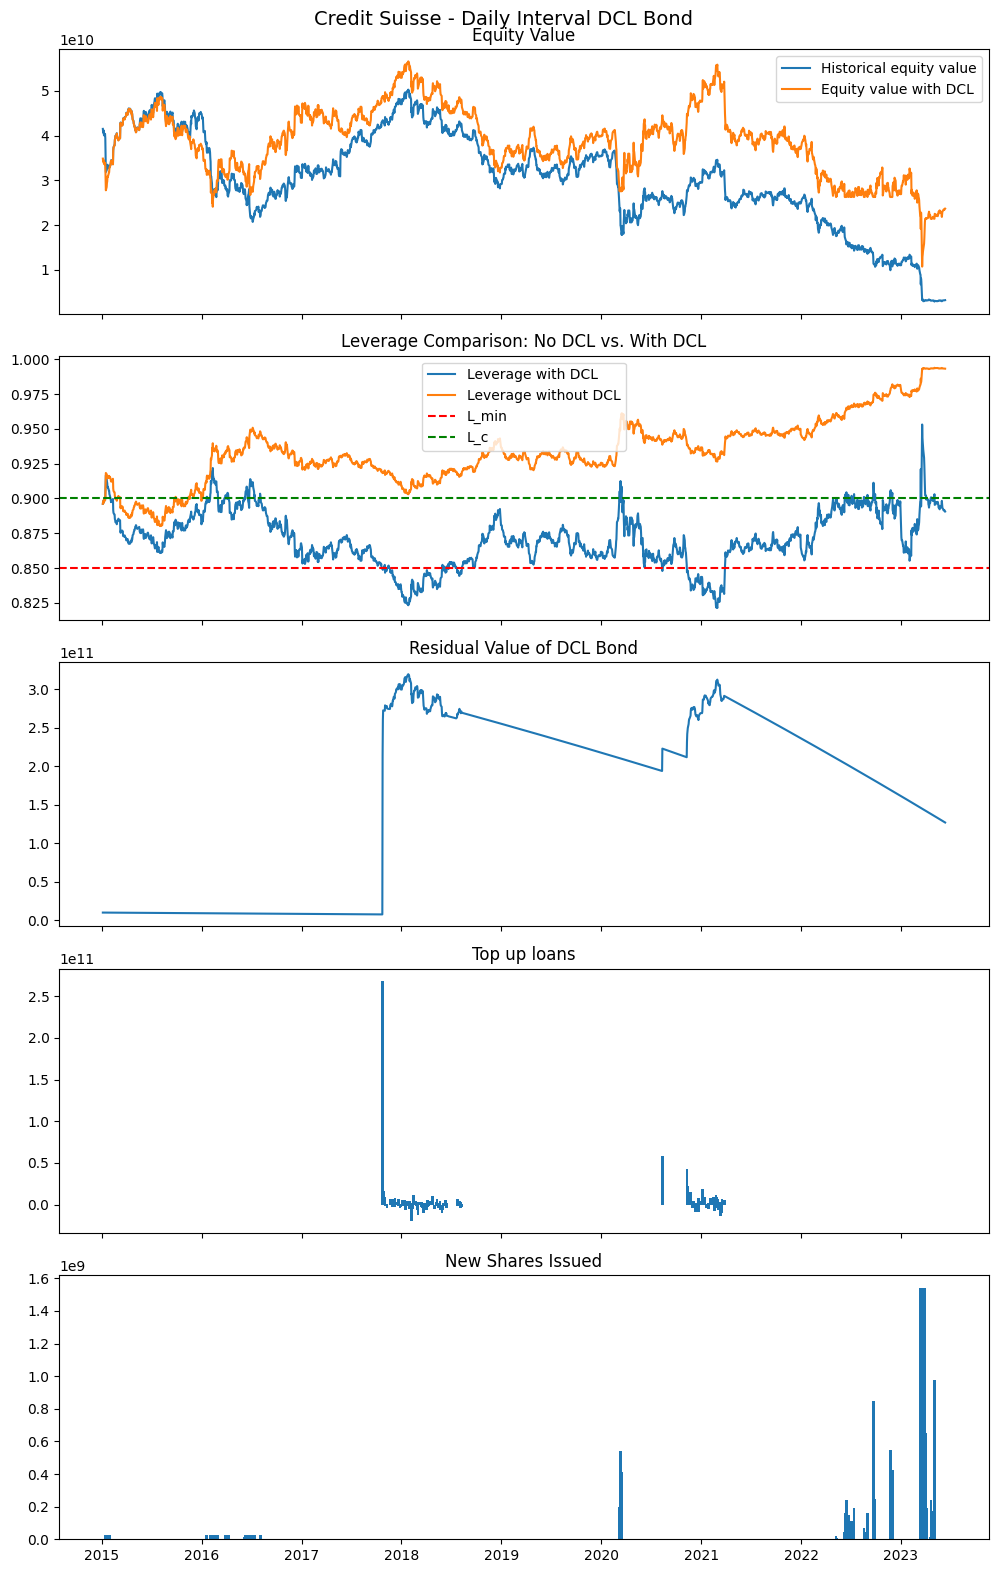

In [16]:
# ------------------------ Plot the results -------------------------

def plot_results(no_dcl_bond: DCL_Bond, dcl_bond: DCL_Bond, title: str) -> None:
    """
    Plot the results. 
    """

    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,16))
    fig.suptitle(title, fontsize=14)
    i = 0

    # # ------------------------------------------------------------------
    # # 1) Stock price
    # # ------------------------------------------------------------------
    # ax[0].plot(dcl_bond.dcl_data.index, dcl_bond.dcl_data['Close'], label='Close')
    # ax[0].set_title('Stock Price')
    # ax[0].legend(loc='best')
    # i += 1

    # ------------------------------------------------------------------
    # Equity value
    # ------------------------------------------------------------------
    # TODO: Veriffy that Company Market Capitalization is correct, it seems to give a larger value than the close * shares outstanding, even at the starting date
    ax[i].plot(dcl_bond.dcl_data.index, dcl_bond.dcl_data['Company Market Capitalization'], label='Historical equity value')
    ax[i].plot(dcl_bond.results.index, dcl_bond.results['Close']*dcl_bond.results['Shares outstanding'], label='Equity value with DCL')
    ax[i].set_title('Equity Value')
    ax[i].legend(loc='best')
    i += 1

    # TODO: Add shares outstanding plot
    # ax[1].plot(df.index, df['Shares outstanding'], label='Shares outstanding')
    # ax[1].set_title('Shares outstanding')

    # ------------------------------------------------------------------
    # 2) Leverage ratio
    # ------------------------------------------------------------------

    ax[i].plot(dcl_bond.results.index, dcl_bond.results['Leverage ratio'], label='Leverage with DCL')
    ax[i].plot(no_dcl_bond.results.index, no_dcl_bond.results['Leverage ratio'], label='Leverage without DCL')
    if dcl_bond.L_min != 0:
        ax[i].axhline(y=dcl_bond.L_min, linestyle='--', label='L_min', color='red')
    if dcl_bond.L_c != 1:
        ax[i].axhline(y=dcl_bond.L_c,   linestyle='--', label='L_c',   color='green')
    # ax[i].set_ylim(dcl_bond.L_min - 0.01, 1)
    # ax[i].set_ylim(0.875, 1)
    ax[i].set_title('Leverage Comparison: No DCL vs. With DCL')
    ax[i].legend(loc='best')
    i += 1

    # ------------------------------------------------------------------
    # 3) Residual value of DCL bond
    # ------------------------------------------------------------------
    ax[i].plot(dcl_bond.results.index, dcl_bond.results['RQ_k'], label='RQ_k')
    ax[i].set_title('Residual Value of DCL Bond')
    # ax[1].legend(loc='best')
    i += 1

    # TODO: Add alpha plot
    # TODO: Add new debt issued plot

    # ------------------------------------------------------------------
    # 4) New Debt Issued
    # ------------------------------------------------------------------
    if dcl_bond.results['Top up loan'].sum() > 0:
        ax[i].bar(dcl_bond.results.index, dcl_bond.results['Top up loan'], label='Top up loan', width=10)
    else:
        ax[i].text(0.5, 0.5, '[No top up loans]', ha='center', va='center', transform=ax[i].transAxes)
    ax[i].set_title('Top up loans')
    i += 1

    # ------------------------------------------------------------------
    # 5) New Shares Issued
    # ------------------------------------------------------------------
    if dcl_bond.results['New shares issued'].sum() > 0:
        ax[i].bar(dcl_bond.results.index, dcl_bond.results['New shares issued'], label='New Shares Issued', width=10)
    else:
        ax[i].text(0.5, 0.5, 'No new shares issued', ha='center', va='center', transform=ax[i].transAxes)
    ax[i].set_title('New Shares Issued')
    i += 1

    # ------------------------------------------------------------------
    # Add vertical lines at the start of each period k
    # ------------------------------------------------------------------
    if dcl_bond.freq <= 52: # Clearer to not have vertical lines for daily intervals
        for k_val in dcl_bond.results['k'].unique():
            # For that k_val, find the first time index (i.e., the earliest date) 
            # in the DataFrame where k == k_val
            first_date_k = dcl_bond.results[dcl_bond.results['k'] == k_val].index[0]
            
            # You can choose on which subplot(s) you want the lines.
            # If you want the line in all subplots, iterate over `ax`. 
            # If you want it only in the last subplot, do just ax[2].axvline(...).
            for axis in ax:
                axis.axvline(first_date_k, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"images/{title}.png")
    plt.show()


plot_results(cs_no_dcl, cs_dcl_yearly, title="Credit Suisse - Yearly Interval DCL Bond")
plot_results(cs_no_dcl, cs_dcl_biannual, title="Credit Suisse - Biannual Interval DCL Bond")
plot_results(cs_no_dcl, cs_dcl_monthly, title="Credit Suisse - Monthly Interval DCL Bond")
plot_results(cs_no_dcl, cs_dcl_daily, title="Credit Suisse - Daily Interval DCL Bond")


In [17]:
# Calculate the book value leverage ratio and compare with DCL values













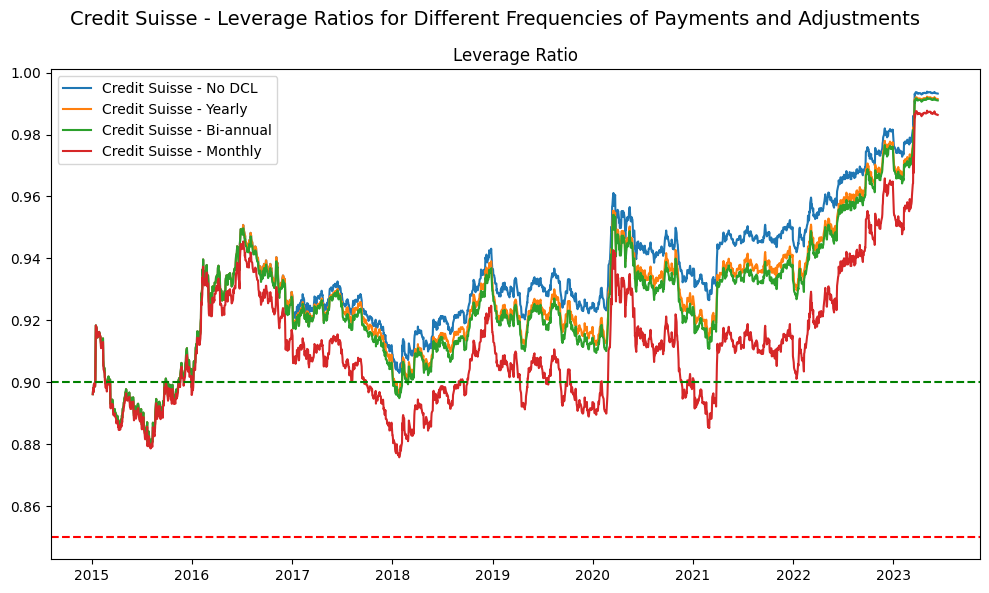

In [18]:
# Compare leverage ratios for different parameters
def plot_leverage_ratios(dcl_bonds: list[DCL_Bond], title: str, interv_lines = False, L_c_lines = True) -> None:
    """
    Plot the leverage ratios. 
    """

    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,6))
    fig.suptitle(title, fontsize=14)

    for dcl_bond in dcl_bonds:
        ax.plot(dcl_bond.results.index, dcl_bond.results['Leverage ratio'], label=f"{dcl_bond.name}")
    if L_c_lines:
        ax.axhline(y=dcl_bond.L_min, linestyle='--', color='red')
        ax.axhline(y=dcl_bond.L_c,   linestyle='--',   color='green')
    if interv_lines:
        for k_val in dcl_bond.results['k'].unique():
            first_date_k = dcl_bond.results[dcl_bond.results['k'] == k_val].index[0]
            ax.axvline(first_date_k, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Leverage Ratio')
    ax.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"images/{title}.png")
    plt.show()


# Compare levarage ratios for different frequencies
plot_leverage_ratios([
    cs_no_dcl, 
    cs_dcl_yearly, 
    cs_dcl_biannual, 
    cs_dcl_monthly, 
    # cs_dcl_daily
    ], 
    title="Credit Suisse - Leverage Ratios for Different Frequencies of Payments and Adjustments",
)



In [19]:
# Compare different conversion prices, S_p

cs_dcl_conversion_prices = [
    DCL_Bond(
        name       = f"Credit Suisse - S_p = {db_S_p}",
        ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
        Q_init     = cs_Q_init,             # Initial value of DCL bonds
        L_min      = cs_L_min,              # Minimum leverage ratio
        L_c        = cs_L_c,                # Critical leverage ratio
        S_p        = db_S_p,                    # Conversion price
        r          = cs_r,                  # Risk free rate TODO: change to timeseries?
        T_years    = 10,                    # Number of years to maturity for DCL bonds
        freq       = 2,              # Frequency of interest payments and leverage considerations
    ) for db_S_p in [40, 20, 10, 5]
]
cs_dcl_conversion_prices.insert(0, cs_no_dcl)


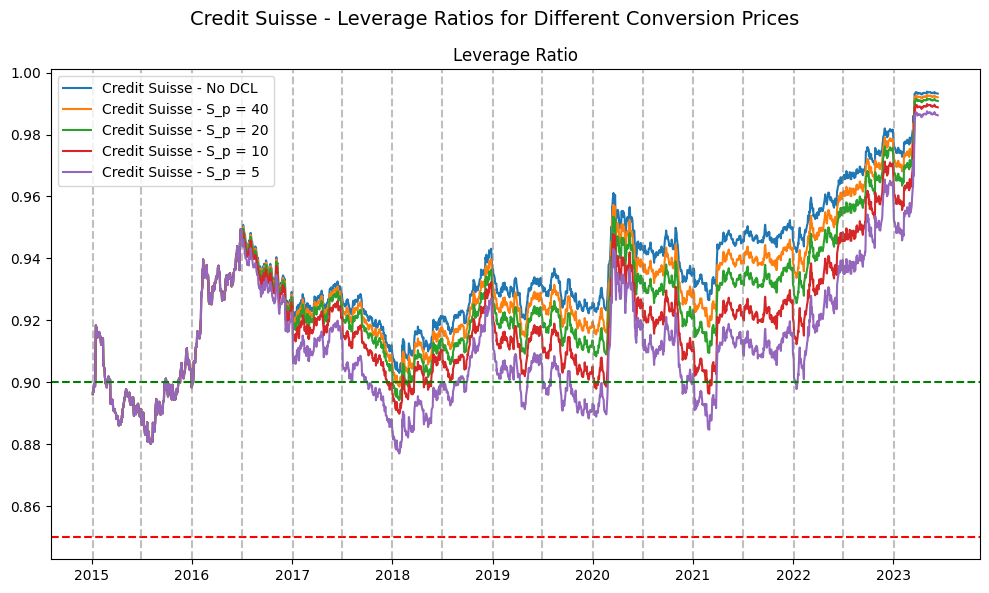

In [20]:
# Plot the leverages different conversion prices
plot_leverage_ratios(cs_dcl_conversion_prices, title="Credit Suisse - Leverage Ratios for Different Conversion Prices", interv_lines = True)


In [21]:
# Compare different L_c values

cs_dcl_leverage_ratios = [
    DCL_Bond(
        name       = f"Credit Suisse - L_c = {db_L_c}",
        ticker_ric = "CSGN.S^F23",          # Reuters Intrument Code (RIC) for the ticker
        Q_init     = cs_Q_init,             # Initial value of DCL bonds
        L_min      = cs_L_min,              # Minimum leverage ratio
        L_c        = db_L_c,                # Critical leverage ratio
        S_p        = "initial share price", # Conversion price
        r          = cs_r,                  # Risk free rate TODO: change to timeseries?
        T_years    = 10,                    # Number of years to maturity for DCL bonds
        freq       = 2,              # Frequency of interest payments and leverage considerations
    ) for db_L_c in [0.94, 0.92, 0.9, 0.88]
]
cs_dcl_leverage_ratios.insert(0, cs_no_dcl)


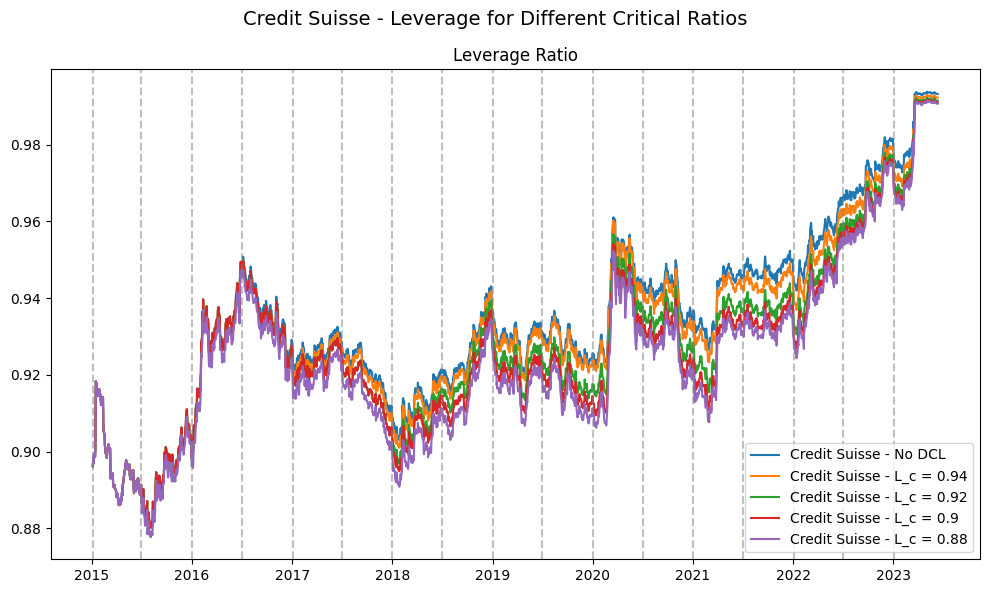

In [22]:
# Plot the leverage for different L_c values

plot_leverage_ratios(cs_dcl_leverage_ratios, title="Credit Suisse - Leverage for Different Critical Ratios", interv_lines = True, L_c_lines = False)


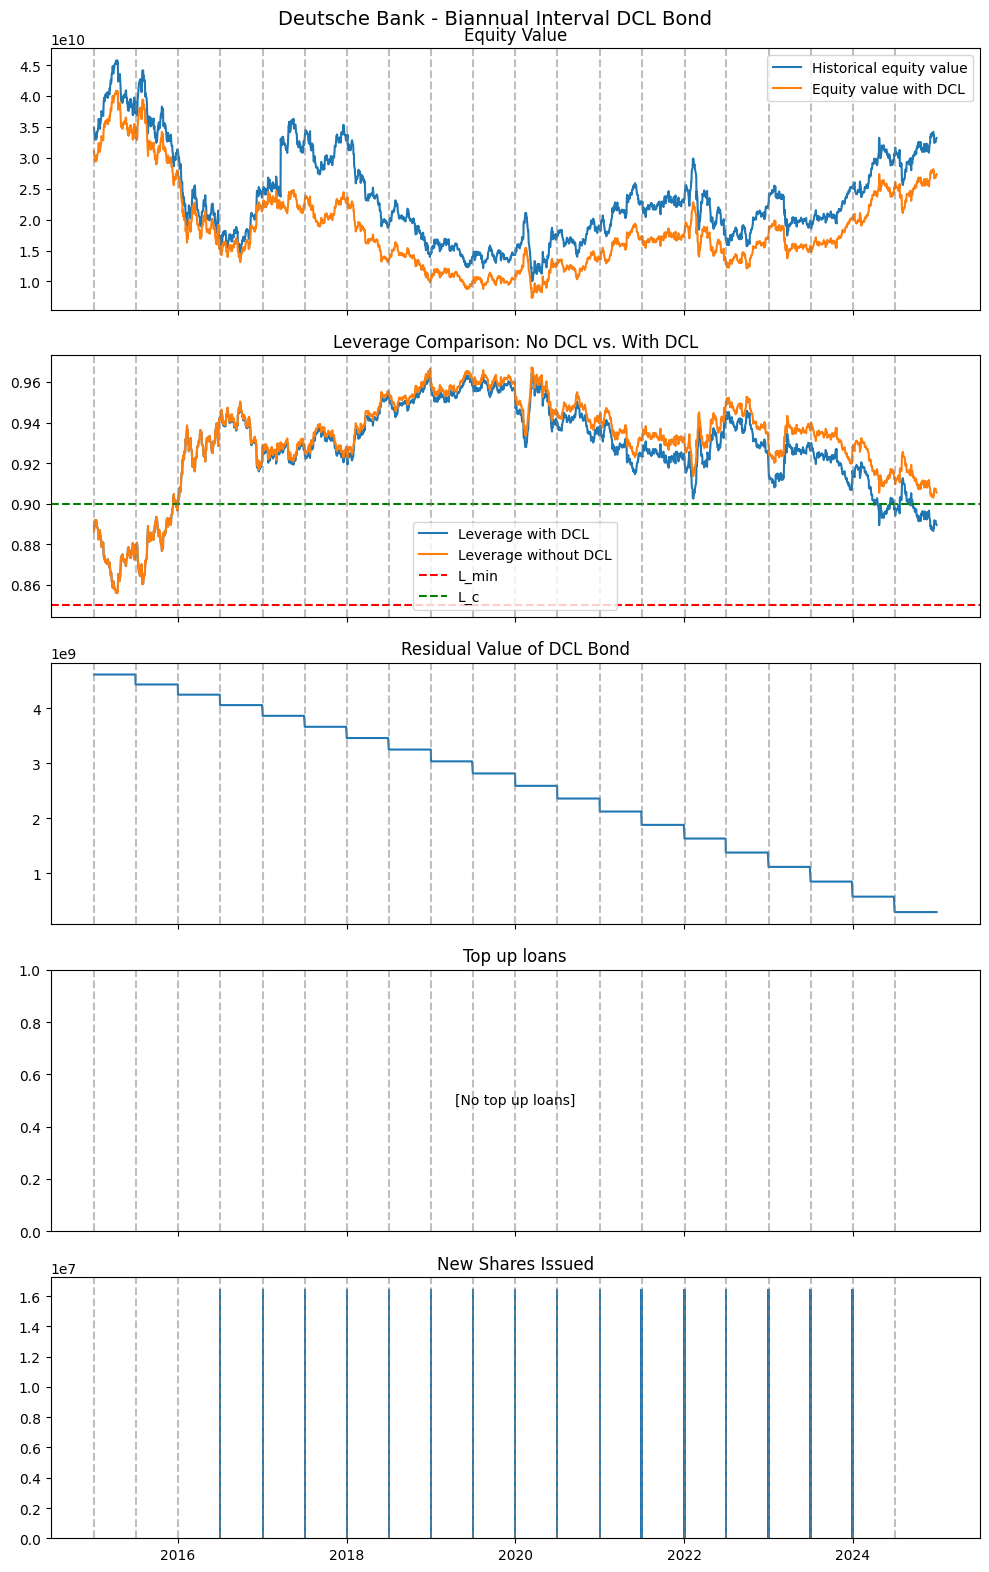

In [ ]:
# --------------------------  Deutsche Bank -------------------------------

db_r = 0.05

# https://investor-relations.db.com/files/documents/annual-reports/Annual_Financial_Statements_and_Management_Report_Deutsche_Bank_AG_2014.pdf?language_id=1#:~:text=The%20bank%20maintained%20its%20stable,end%202014
db_Q_init = 4_619_000_000 # Total AT1 debt for Deutsche Bank in 31 December 2024

db_L_min = 0.85
db_L_c   = 0.9

db_dcl_biannual = DCL_Bond(
    name       = "Deutsche Bank - DCL",
    ticker_ric = "DBKGn.DE",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = db_Q_init,             # Initial value of DCL bonds
    L_min      = db_L_min,              # Minimum leverage ratio
    L_c        = db_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = db_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 2,              # Frequency of interest payments and leverage considerations
)

db_no_dcl = DCL_Bond(
    name       = "Deutsche Bank - No DCL",
    ticker_ric = "DBKGn.DE",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = 1,                     # Initial value of DCL bonds
    L_min      = db_L_min,              # Minimum leverage ratio
    L_c        = db_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = db_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 0,         # Frequency of interest payments and leverage considerations
)


plot_results(db_no_dcl, db_dcl_biannual, title="Deutsche Bank - Biannual Interval DCL Bond")



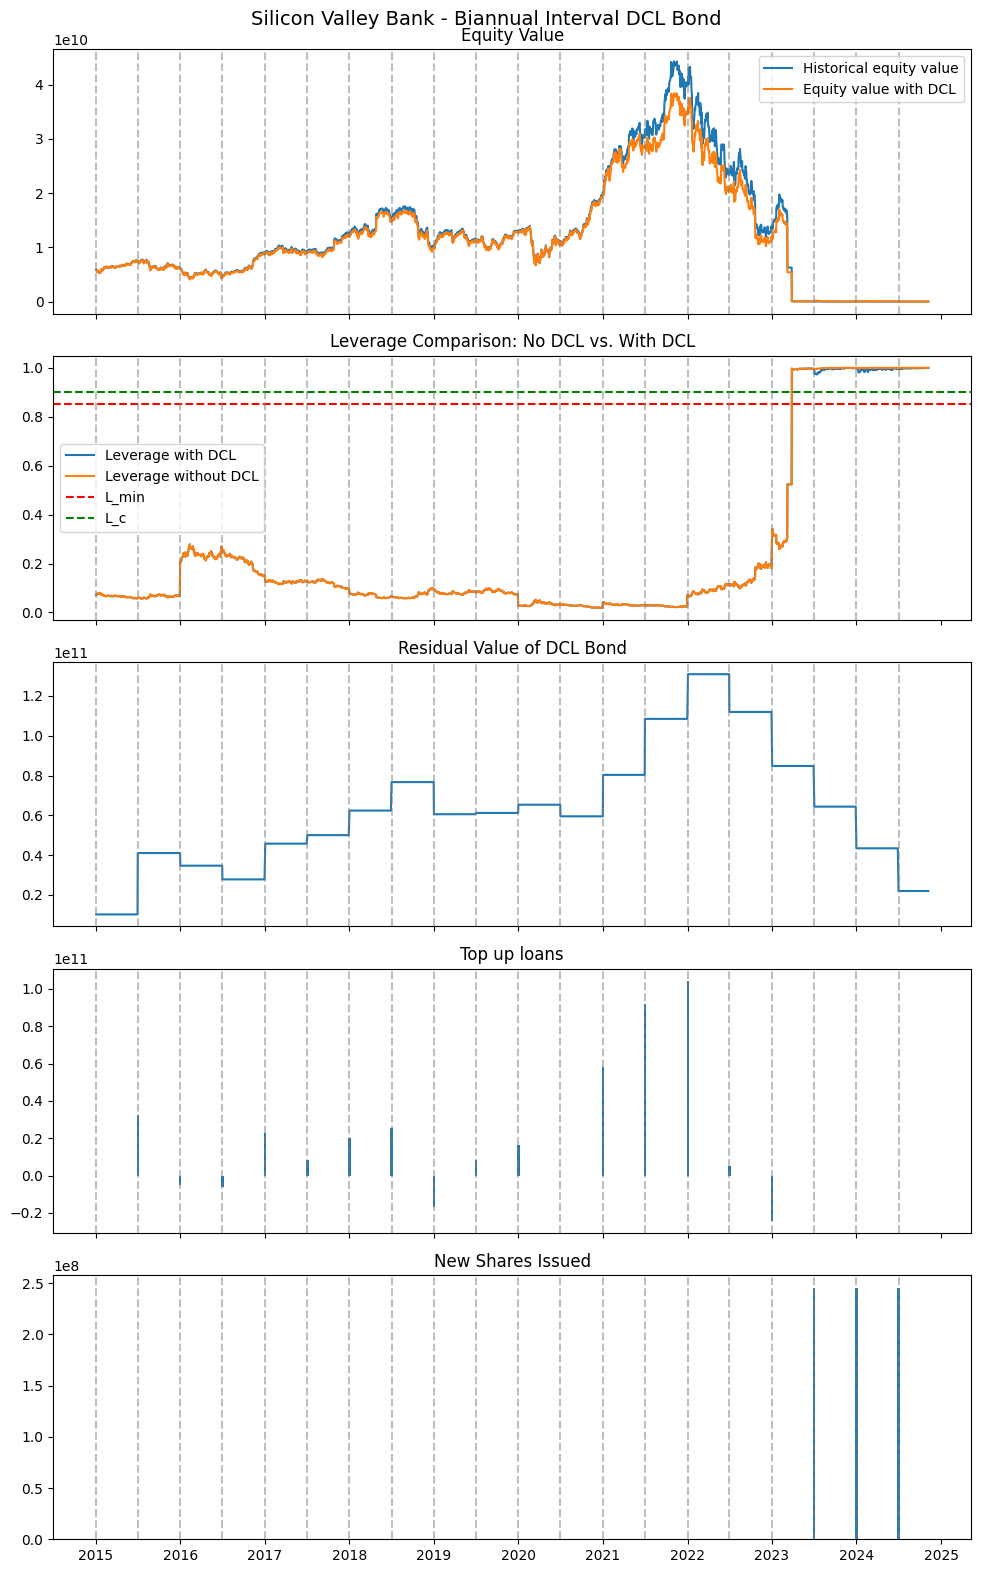

In [24]:
# --------------------------  Silicon Valley Bank -------------------------------

sv_r = 0.05
sv_Q_init = 10_216_000_000 # TODO: find Initial value of DCL bonds -> Set to initial AT1 debt value
sv_L_min = 0.85
sv_L_c   = 0.9

sv_dcl_biannual = DCL_Bond(
    name       = "Silicon Valley Bank - DCL",
    ticker_ric = "SIVBQ.PK^K24",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = sv_Q_init,             # Initial value of DCL bonds
    L_min      = sv_L_min,              # Minimum leverage ratio
    L_c        = sv_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = sv_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 2,              # Frequency of interest payments and leverage considerations
)

sv_no_dcl = DCL_Bond(
    name       = "Silicon Valley Bank - No DCL",
    ticker_ric = "SIVBQ.PK^K24",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = 1,                     # Initial value of DCL bonds
    L_min      = sv_L_min,              # Minimum leverage ratio
    L_c        = sv_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = sv_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 0,         # Frequency of interest payments and leverage considerations
)

plot_results(sv_no_dcl, sv_dcl_biannual, title="Silicon Valley Bank - Biannual Interval DCL Bond")


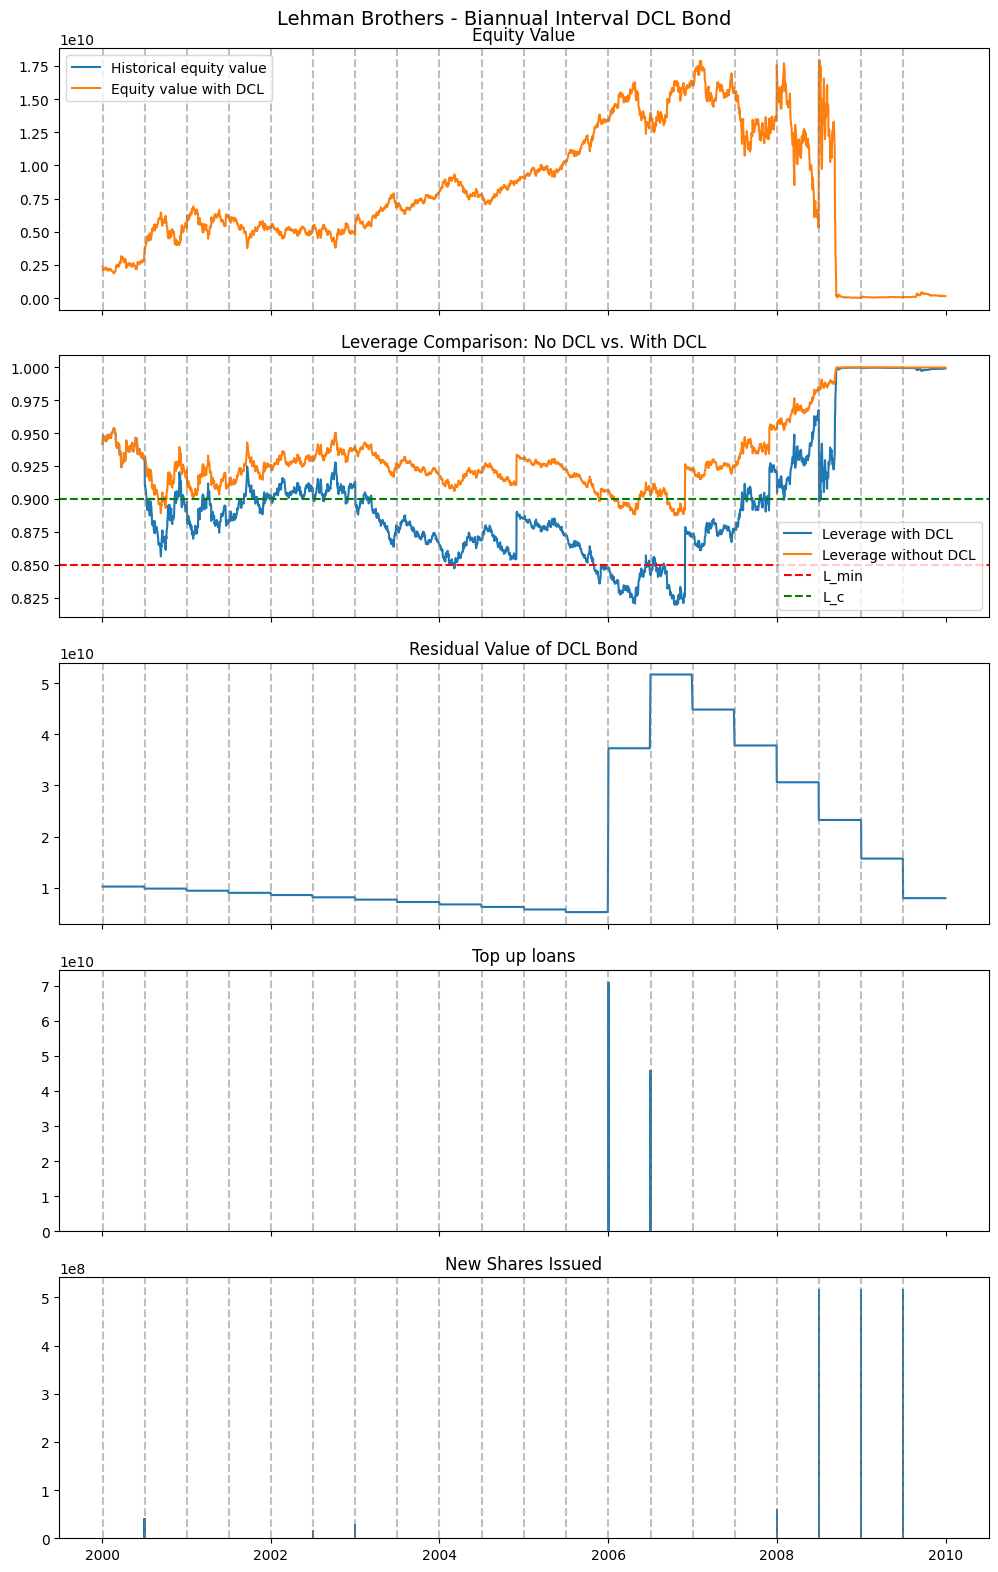

In [25]:
# --------------------------  Lehman Brothers -------------------------------

le_r = 0.05
le_Q_init = 10_216_000_000 # TODO: find Initial value of DCL bonds -> Set to initial AT1 debt value
le_L_min = 0.85
le_L_c   = 0.9

le_dcl_biannual = DCL_Bond(
    name       = "Lehman Brothers - DCL",
    ticker_ric = "LEHMQ.PK^C12",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = le_Q_init,             # Initial value of DCL bonds
    L_min      = le_L_min,              # Minimum leverage ratio
    L_c        = le_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = le_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 2,              # Frequency of interest payments and leverage considerations
)

le_no_dcl = DCL_Bond(
    name       = "SLehman Brothers- No DCL",
    ticker_ric = "LEHMQ.PK^C12",          # Reuters Intrument Code (RIC) for the ticker
    Q_init     = 1,                     # Initial value of DCL bonds
    L_min      = le_L_min,              # Minimum leverage ratio
    L_c        = le_L_c,                # Critical leverage ratio
    S_p        = "initial share price", # Conversion price
    r          = le_r,                  # Risk free rate TODO: change to timeseries?
    T_years    = 10,                    # Number of years to maturity for DCL bonds
    freq       = 0,         # Frequency of interest payments and leverage considerations
)

plot_results(le_no_dcl, le_dcl_biannual, title="Lehman Brothers - Biannual Interval DCL Bond")


In [26]:
# Calculate total value of dilutions for new shares issued

def calculate_total_dilution(dcl_bond: DCL_Bond):
    dilutions = dcl_bond.results['New shares issued'] * dcl_bond.results['Close']
    total = dilutions.sum()
    print(f"    {dcl_bond.name}: {total:>15,.0f} CHF")

print("Total dilution from share issuances of DCL bonds - Credit Suisse: ")
calculate_total_dilution(cs_dcl_daily)
calculate_total_dilution(cs_dcl_monthly)
calculate_total_dilution(cs_dcl_biannual)
calculate_total_dilution(cs_dcl_yearly)
print("Total dilution from share issuances of DCL bonds - Deutsche Bank:")
calculate_total_dilution(db_dcl_biannual)

print("Dilutions for different S_p values")
for dcl_bond in cs_dcl_conversion_prices:
    calculate_total_dilution(dcl_bond)

print("Diltuions for different L_c values")
for dcl_bond in cs_dcl_leverage_ratios:
    calculate_total_dilution(dcl_bond)



Total dilution from share issuances of DCL bonds - Credit Suisse: 
    Credit Suisse - Daily:  65,793,982,677 CHF
    Credit Suisse - Monthly:  15,865,642,241 CHF
    Credit Suisse - Bi-annual:   5,539,160,028 CHF
    Credit Suisse - Yearly:   4,550,818,975 CHF
Total dilution from share issuances of DCL bonds - Deutsche Bank:
    Deutsche Bank - DCL:   2,786,435,794 CHF
Dilutions for different S_p values
    Credit Suisse - No DCL:               0 CHF
    Credit Suisse - S_p = 40:   3,003,164,177 CHF
    Credit Suisse - S_p = 20:   6,006,328,354 CHF
    Credit Suisse - S_p = 10:  10,662,511,556 CHF
    Credit Suisse - S_p = 5:  15,764,266,353 CHF
Diltuions for different L_c values
    Credit Suisse - No DCL:               0 CHF
    Credit Suisse - L_c = 0.94:   1,660,936,706 CHF
    Credit Suisse - L_c = 0.92:   3,918,342,039 CHF
    Credit Suisse - L_c = 0.9:   5,539,160,028 CHF
    Credit Suisse - L_c = 0.88:   7,175,872,082 CHF
